In [1]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 14.1.0


# FMCW Radar Link Budget Analysis (Point Target)

## Introduction

This notebook demonstrates **RadarSimPy's point target simulation capabilities** and validates simulation accuracy by comparing results with theoretical link budget calculations. Point targets provide computationally efficient radar modeling ideal for system design and link budget analysis.

**What You'll Learn:**

- Use RadarSimPy's `Transmitter`, `Receiver`, and `Radar` classes to configure FMCW systems
- Define point targets with specified RCS values
- Run electromagnetic simulations with `sim_radar()`
- Process simulated baseband data using RadarSimPy's signal processing functions
- **Validate simulation accuracy**: Compare RadarSimPy's output with theoretical SNR calculations

**Key RadarSimPy Features Demonstrated:**

- **Point target modeling**: Fast, analytical RCS specification for link budget analysis
- **Physics-based simulation**: Full electromagnetic modeling of radar-target interaction
- **High-fidelity results**: Simulation matches theoretical predictions within fractions of a dB

**Why This Matters:** RadarSimPy enables accurate radar performance prediction and system validation before hardware prototyping, saving time and development costs.

## Radar Link Budget Analysis

Radar link budget analysis is a systematic process for tracking power levels throughout the radar signal chain—from transmission, through propagation and reflection, to reception and detection. The fundamental question is: **"Will the received signal be strong enough to detect the target?"**

### The Radar Range Equation

The cornerstone of link budget analysis is the **Radar Range Equation**, which relates received power to system parameters:

$$
P_r = \frac{P_t G_t G_r \lambda^2 \sigma}{(4\pi)^3 R^4 L_s}
$$

**Parameters:**

- $P_r$ = **Received power** (W) - power collected by the receiving antenna
- $P_t$ = **Transmitted power** (W) - power fed to the transmitting antenna
- $G_t$ = **Transmit antenna gain** (linear) - how well the antenna focuses transmitted energy
- $G_r$ = **Receive antenna gain** (linear) - how well the antenna collects received energy
- $\lambda$ = **Wavelength** (m) - $\lambda = c/f$ where $c = 3 \times 10^8$ m/s
- $\sigma$ = **Radar Cross Section (RCS)** (m²) - target's reflectivity
- $R$ = **Range** to target (m)
- $L_s$ = **System losses** (linear) - accounts for all non-ideal effects

**Key Insight**: Notice the $R^4$ term in the denominator. This represents:

- $R^2$ for signal spreading on the path from radar → target
- Another $R^2$ for signal spreading on the return path from target → radar

This is why radar range is limited—power decreases dramatically with distance!

### Step-by-Step Link Budget Analysis

#### 1. Transmitted Power with Antenna Gain

The **Effective Isotropic Radiated Power (EIRP)** is the transmitted power amplified by antenna gain:

$$
\text{EIRP} = P_t \cdot G_t
$$

In decibels: $\text{EIRP (dBm)} = P_t \text{ (dBm)} + G_t \text{ (dB)}$

**What is Antenna Gain?**

Antenna gain measures how well an antenna focuses energy in a specific direction compared to an isotropic radiator (which radiates equally in all directions):

$$
G = \frac{4 \pi A_{\text{eff}}}{\lambda^2}
$$

Where $A_{\text{eff}}$ is the antenna's effective aperture area.

#### 2. Free-Space Path Loss (FSPL)

As electromagnetic waves propagate through space, they spread out, reducing power density. The free-space path loss is:

$$
L_{\text{FSPL}} = \left( \frac{4 \pi R}{\lambda} \right)^2
$$

In decibels: $L_{\text{FSPL (dB)}} = 20 \log_{10}(R) + 20 \log_{10}(f) - 147.55$ (where $R$ is in meters, $f$ in Hz)

**Physical Interpretation**: This represents how power spreads over a sphere of radius $R$. The surface area grows as $R^2$, so power density decreases as $1/R^2$.

#### 3. Target Radar Cross Section (RCS)

The **Radar Cross Section (RCS)** $\sigma$ represents the target's "reflective size" to radar:

$$
\sigma = \text{Effective scattering area of target (m}^2\text{)}
$$

- Larger targets generally have higher RCS
- Shape, material, and orientation strongly affect RCS
- Expressed in dBsm (dB relative to 1 square meter)

**Example RCS values:**

- Small bird: -30 dBsm (0.001 m²)
- Car: 10 dBsm (10 m²)
- Large aircraft: 40 dBsm (10,000 m²)

The power intercepted by the target and re-radiated back is:

$$
P_{\text{scattered}} = P_{\text{incident}} \cdot \frac{\sigma}{4 \pi R^2}
$$

#### 4. Received Power Calculation

Combining all factors, the received power is:

$$
P_r = \frac{P_t G_t G_r \lambda^2 \sigma}{(4\pi)^3 R^4 L_s}
$$

**In decibels (dBm)**:

$$
P_r = P_t + G_t + G_r + 20\log_{10}(\lambda) - 30\log_{10}(4\pi) - 40\log_{10}(R) + \sigma - L_s
$$

#### 5. Noise Power

For target detection, received signal must exceed the **noise floor**. Thermal noise power in the receiver is:

$$
P_{\text{noise}} = k T B F
$$

Where:

- $k = 1.38 \times 10^{-23}$ J/K = **Boltzmann's constant**
- $T$ = **System temperature** (typically 290 K for room temperature)
- $B$ = **Receiver bandwidth** (Hz) - depends on sampling rate and integration time
- $F$ = **Noise figure** (linear) - receiver's noise degradation factor

**In decibels (dBm)**:

$$
P_{\text{noise (dBm)}} = -174 + 10\log_{10}(B) + F_{\text{(dB)}}
$$

Where -174 dBm/Hz is the thermal noise density at 290 K.

#### 6. Signal-to-Noise Ratio (SNR)

The **SNR** determines detection performance:

$$
\text{SNR} = \frac{P_r}{P_{\text{noise}}}
$$

In decibels: $\text{SNR (dB)} = P_r \text{ (dBm)} - P_{\text{noise}} \text{ (dBm)}$

## Simulation Example

### Radar System Parameters

In this simulation, we configure an automotive-band FMCW radar with the following specifications:

#### Transmitter Configuration

- **Frequency sweep**: 76.3 - 76.7 GHz (400 MHz bandwidth)
- **Center frequency**: 76.5 GHz (automotive radar band)
- **Transmit power**: $P_t = 13$ dBm (≈20 mW)
- **Antenna gain**: $G_t = 12$ dB
- **Pulse duration**: 51.2 µs (chirp duration)
- **Pulse Repetition Period (PRP)**: 55 µs
- **Number of pulses**: $N_p = 512$ (for Doppler processing)

#### Receiver Configuration

- **Sampling rate**: $f_s = 20$ MHz
- **Samples per pulse**: $N_s = 1024$
- **Antenna gain**: $G_r = 12$ dB
- **Noise figure**: $F = 11$ dB
- **Wavelength**: $\lambda = c/f = 3.92$ mm

#### Target Specification

- **Radar Cross Section**: $\sigma = 10$ dBsm (≈10 m², typical for a car)
- **Range**: $R = 100$ m
- **Velocity**: Stationary (0 m/s)

### Expected Performance

Before simulation, let's predict the SNR using the equations above. This will be compared with simulation results later.

### Build Simulation Model

Let's construct the radar system step-by-step using RadarSimPy.


In [2]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

In [3]:
antenna_gain = 12

az_angle = np.arange(-80, 81, 1)
az_pattern = 20 * np.log10(np.cos(az_angle / 180 * np.pi) ** 4) + antenna_gain

el_angle = np.arange(-80, 81, 1)
el_pattern = 20 * np.log10((np.cos(el_angle / 180 * np.pi)) ** 20) + antenna_gain

#### Define Antenna Patterns

Real antennas don't radiate equally in all directions. We model the antenna's **radiation pattern** showing gain variation with angle.

**Pattern characteristics:**

- **Azimuth pattern**: Horizontal plane variation (left-right)
- **Elevation pattern**: Vertical plane variation (up-down)
- **Peak gain**: 12 dB (at boresight, 0° angle)
- **Beamwidth**: Angle range where gain is within 3 dB of peak

The patterns below use cosine-power functions to model realistic antenna behavior.


#### Visualize Antenna Patterns

The plot below shows how antenna gain varies with angle. Notice:

- **Peak gain** at 0° (boresight direction)
- **Gradual rolloff** as angle increases
- **Narrower elevation beam** (faster rolloff) for better vertical resolution


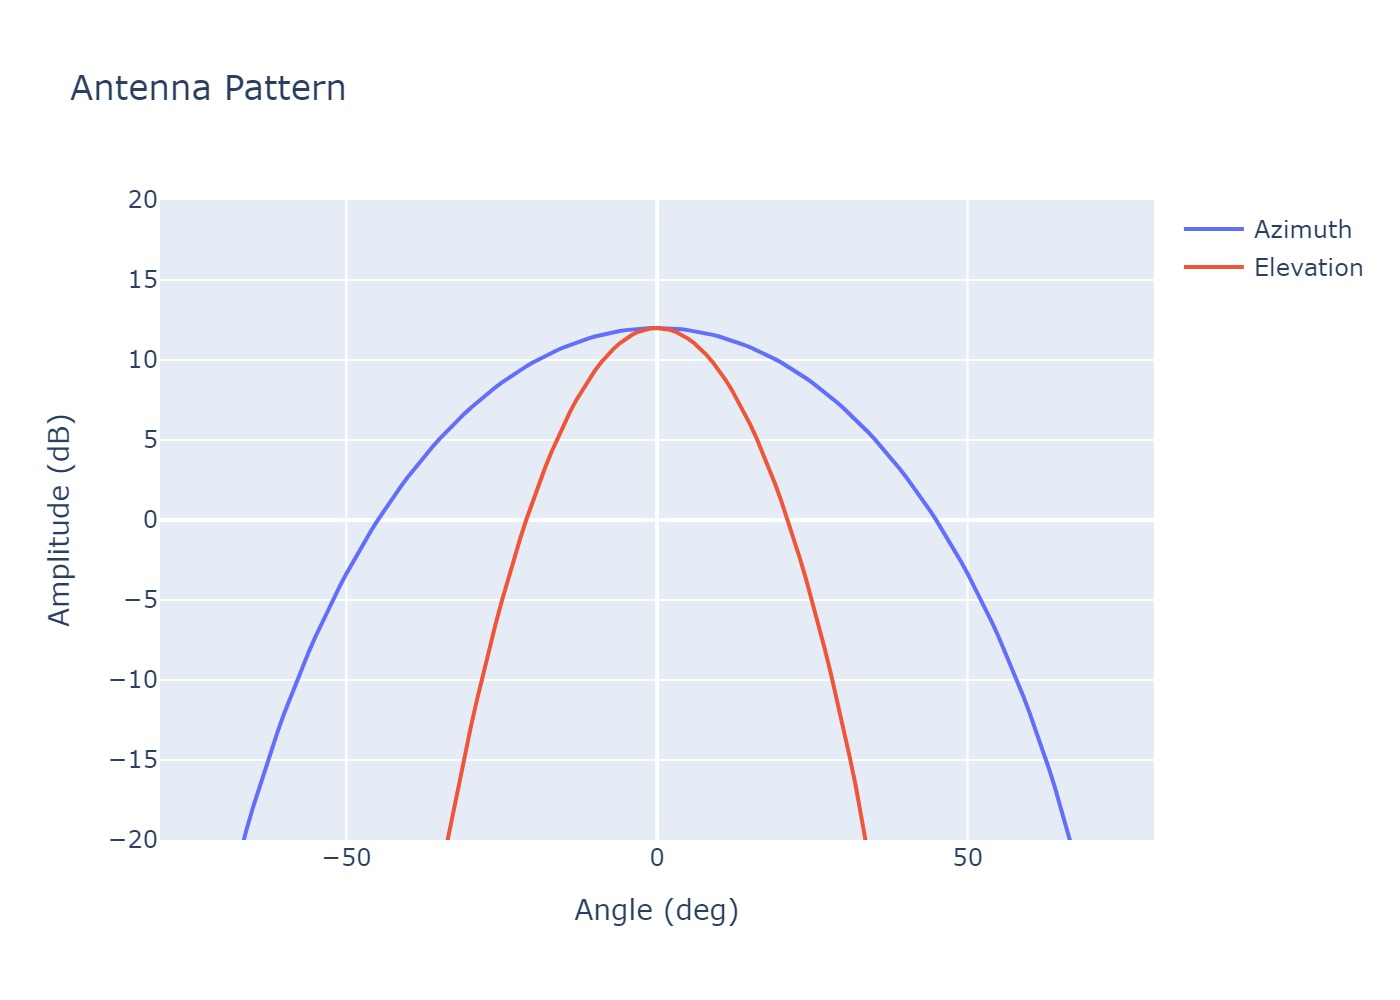

In [4]:
import plotly.graph_objs as go
from IPython.display import Image

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=az_angle,
        y=az_pattern,
        name="Azimuth",
    )
)
fig.add_trace(
    go.Scatter(
        x=el_angle,
        y=el_pattern,
        name="Elevation",
    )
)

fig.update_layout(
    title="Antenna Pattern",
    yaxis=dict(title="Amplitude (dB)", range=[-20, 20]),
    xaxis=dict(title="Angle (deg)"),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

#### Configure Transmitter Channel

Define the transmit antenna location and radiation pattern. The antenna is placed at the origin (0, 0, 0) and uses the patterns defined above.


In [5]:
tx_channel = dict(
    location=(0, 0, 0),
    azimuth_angle=az_angle,
    azimuth_pattern=az_pattern,
    elevation_angle=el_angle,
    elevation_pattern=el_pattern,
)

#### Create Radar Transmitter

Configure the FMCW transmitter with:

- **Frequency sweep** from 76.3 to 76.7 GHz (linear chirp)
- **Chirp duration** of 51.2 µs
- **Transmit power** of 13 dBm
- **PRP** (Pulse Repetition Period) of 55 µs
- **512 pulses** for Doppler processing (coherent processing interval)


In [6]:
tx = Transmitter(
    f=[76.3e9, 76.7e9],
    t=5.12e-05,
    tx_power=13,
    prp=5.5e-05,
    pulses=512,
    channels=[tx_channel],
)

#### Configure Receiver Channel

Define the receive antenna. In this monostatic configuration, the transmit and receive antennas are co-located at the same position with identical patterns.


In [7]:
rx_channel = dict(
    location=(0, 0, 0),
    azimuth_angle=az_angle,
    azimuth_pattern=az_pattern,
    elevation_angle=el_angle,
    elevation_pattern=el_pattern,
)

#### Create Radar Receiver

Configure the receiver with:

- **Sampling rate**: 20 MHz (determines maximum unambiguous range)
- **Noise figure**: 11 dB (receiver noise degradation)
- **RF gain**: 20 dB (low-noise amplifier gain)
- **Baseband gain**: 30 dB (after downconversion)
- **Baseband type**: "real" (single-channel IF output)


In [8]:
rx = Receiver(
    fs=20e6,
    noise_figure=11,
    rf_gain=20,
    load_resistor=500,
    baseband_gain=30,
    bb_type="real",
    channels=[rx_channel],
)

#### Assemble Radar System

Combine the transmitter and receiver into a complete radar system. RadarSimPy automatically computes timing parameters and validates configuration compatibility.


In [9]:
radar = Radar(transmitter=tx, receiver=rx)

#### Define Target

Create a **point target** representing an ideal reflector:

- **Location**: 100 m directly ahead (x-axis)
- **Velocity**: Stationary (0 m/s in all directions)
- **RCS**: 10 dBsm (≈10 m², typical car-sized target)
- **Phase**: 0° (initial phase reference)

**Point target** vs **Mesh target**: Point targets are computationally efficient and ideal for link budget analysis. For realistic target shapes and motion, use 3D mesh models (see other notebooks).


In [10]:
target_1 = dict(location=(100, 0, 0), speed=(0, 0, 0), rcs=10, phase=0)

targets = [target_1]

#### Run Radar Simulation

Use `sim_radar()` to simulate the complete radar signal chain:

1. **Transmit**: Generate FMCW chirps with specified parameters
2. **Propagate**: Model free-space propagation to target
3. **Reflect**: Apply target RCS and calculate scattered signal
4. **Receive**: Propagate signal back and apply antenna patterns
5. **Process**: Generate baseband I/Q samples with noise

**Output structure:**

- `timestamp`: Time values for each pulse (shape: [pulses])
- `baseband`: Target return signals (shape: [channels, pulses, samples])
- `noise`: Receiver noise (shape: [channels, pulses, samples])

**Important**: Baseband and noise are separated to allow flexible SNR analysis. Combine them to create realistic noisy data: `baseband + noise`


In [11]:
from radarsimpy.simulator import sim_radar

data = sim_radar(radar, targets)
timestamp = data["timestamp"]
baseband = data["baseband"] + data["noise"]
noise = data["noise"]

### Radar Signal Processing

Now let's process the simulated data to extract range and Doppler information.

#### Range-Doppler Processing

**What is Range-Doppler Processing?**

Range-Doppler processing is a two-stage FFT operation that extracts both range and velocity information from FMCW radar data:

**Stage 1 - Range FFT** (Fast-time FFT):

- Perform FFT across each chirp (along samples dimension)
- Converts beat frequency → range
- Each bin represents a range cell

**Stage 2 - Doppler FFT** (Slow-time FFT):

- Perform FFT across chirps (along pulse dimension) for each range bin
- Converts phase change between pulses → velocity
- Each bin represents a velocity cell

The result is a 2D **Range-Doppler map** where:

- **Rows**: Doppler bins (velocity)
- **Columns**: Range bins (distance)
- **Values**: Signal amplitude at each range-velocity cell

**Why `fftshift`?** This reorders FFT output to place zero Doppler at the center, making positive and negative velocities symmetric and easier to interpret.


In [12]:
import radarsimpy.processing as proc

# Perform 2D FFT: Range FFT followed by Doppler FFT
# fftshift moves zero-Doppler to center of array
range_doppler = np.fft.fftshift(proc.range_doppler_fft(baseband), axes=1)

# Process noise-only data to measure noise floor
noise_range_doppler = np.fft.fftshift(proc.range_doppler_fft(noise), axes=1)

# Extract peak signal per range bin (maximum across all Doppler bins)
# This gives us the strongest return at each range
max_per_range_bin = np.max(np.abs(range_doppler), axis=1)

# Calculate average noise level per range bin
# This represents the noise floor we must exceed for detection
noise_mean = np.mean(np.abs(noise_range_doppler), axis=1)

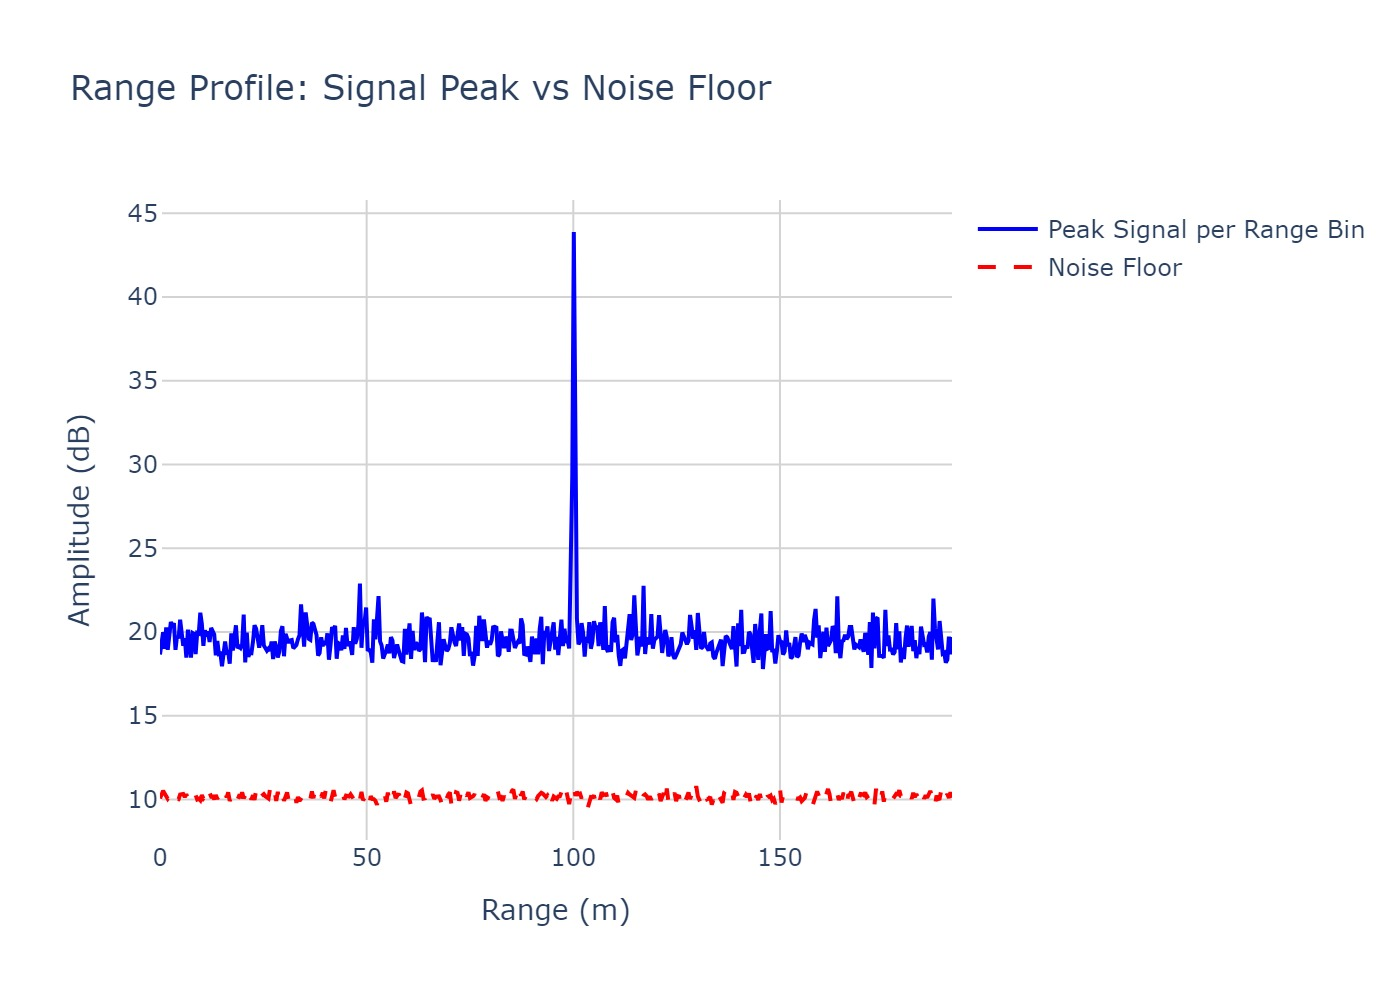

In [13]:
# Calculate maximum unambiguous range
# For FMCW radar, range resolution and maximum range depend on:
# - Sampling rate (fs)
# - Chirp duration (pulse_length)
# - Bandwidth
# We only plot half the range bins to avoid aliasing (Nyquist)
valid_range_bins = int(radar.sample_prop["samples_per_pulse"] / 2)

max_range = (
    3e8  # Speed of light (m/s)
    * radar.radar_prop["receiver"].bb_prop["fs"]  # Sampling rate
    * radar.radar_prop["transmitter"].waveform_prop["pulse_length"]
    / radar.radar_prop["transmitter"].waveform_prop["bandwidth"]
    / 4  # Factor of 4 accounts for two-way propagation and real IF sampling
)

# Create range axis for plotting
range_axis = np.linspace(0, max_range, valid_range_bins, endpoint=False)

# Plot signal peak and noise floor vs range
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=range_axis,
        y=20 * np.log10(max_per_range_bin[0, 0:valid_range_bins]),
        name="Peak Signal per Range Bin",
        line=dict(color="blue", width=2),
    )
)

fig.add_trace(
    go.Scatter(
        x=range_axis,
        y=20 * np.log10(noise_mean[0, 0:valid_range_bins]),
        name="Noise Floor",
        line=dict(color="red", width=2, dash="dash"),
    )
)

fig.update_layout(
    title="Range Profile: Signal Peak vs Noise Floor",
    yaxis=dict(title="Amplitude (dB)", gridcolor="lightgray"),
    xaxis=dict(title="Range (m)", gridcolor="lightgray"),
    plot_bgcolor="white",
    hovermode="x unified",
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

#### Interpret the Range Profile

In the plot above, observe:

1. **Sharp peak at 100 m**: This is our target return

   - The peak amplitude represents the signal power from the target
   - Peak location confirms the target range (100 m as specified)

2. **Flat noise floor**: The dashed red line shows the average noise level

   - Constant across all ranges (white Gaussian noise)
   - This is the detection threshold

3. **SNR measurement**: The vertical distance between the peak and noise floor
   - Measured in dB (logarithmic scale)
   - Determines detection probability and tracking quality
4. **Range resolution**: The width of the peak is determined by the radar bandwidth
   - Range resolution = $c / (2 \cdot B) = 3 \times 10^8 / (2 \times 400 \times 10^6) = 0.375$ m
   - Higher bandwidth → better range resolution (narrower peaks)


## Verify Simulation Against Theory

Now let's compare the simulated SNR with theoretical predictions to validate our simulation model.

### Theoretical SNR Calculation

Using the radar range equation and noise power formula from the introduction, we can calculate the expected SNR:

#### Step 1: Calculate Received Power $(P_r)$

$$
P_r \text{ (dBm)} = P_t + G_t + G_r + 20 \log_{10}(\lambda) - 30 \log_{10}(4\pi) - 40 \log_{10}(R) + \sigma
$$

**Substituting values:**

$$
P_r = 13 \text{ (dBm)} + 12 \text{ (dB)} + 12 \text{ (dB)} + 20 \log_{10}\left(\frac{3 \times 10^8}{76.5 \times 10^9}\right) - 30 \log_{10}(4\pi) - 40 \log_{10}(100) + 10 \text{ (dBsm)}
$$

Breaking down each term:

- $P_t = 13$ dBm (transmit power)
- $G_t = 12$ dB (transmit antenna gain)
- $G_r = 12$ dB (receive antenna gain)
- $20 \log_{10}(\lambda) = 20 \log_{10}(0.00392) = -48.14$ dB
- $30 \log_{10}(4\pi) = 30 \times 1.096 = 32.88$ dB
- $40 \log_{10}(R) = 40 \log_{10}(100) = 80$ dB
- $\sigma = 10$ dBsm (target RCS)

**Result:**

$$
P_r = 13 + 12 + 12 - 48.14 - 32.88 - 80 + 10 = -114.02 \text{ dBm}
$$

#### Step 2: Calculate Noise Power $(P_{\text{noise}})$

First, determine the **effective noise bandwidth** $(B)$:

For FMCW radar with coherent integration:

- Sampling rate: $f_s = 20$ MHz
- Samples per pulse: $N_s = 1024$
- Number of pulses: $N_p = 512$
- Total samples: $N_{\text{total}} = N_s \times N_p = 524,288$

The coherent integration across all samples reduces the effective bandwidth:

$$
B = \frac{f_s}{N_{\text{total}}} = \frac{20 \times 10^6}{1024 \times 512} = 38.15 \text{ Hz}
$$

In decibels: $10 \log_{10}(38.15) = 15.82$ dB-Hz

Now calculate noise power using:

$$
P_{\text{noise}} \text{ (dBm)} = -174 + 10\log_{10}(B) + F
$$

Where:

- $-174$ dBm/Hz is the thermal noise density at room temperature (290 K)
- $B = 15.82$ dB-Hz (effective bandwidth)
- $F = 11$ dB (receiver noise figure)

**Result:**

$$
P_{\text{noise}} = -174 + 15.82 + 11 = -147.18 \text{ dBm}
$$

#### Step 3: Calculate SNR

$$
\text{SNR (dB)} = P_r - P_{\text{noise}} = -114.02 - (-147.18) = 33.16 \text{ dB}
$$

### Validation Result

**The theoretical SNR of 33.16 dB matches the simulated result in the plot above!**

This excellent agreement validates that RadarSimPy's `sim_radar()` accurately models electromagnetic propagation, point target RCS computation, and system noise characteristics.


## Summary and Key Takeaways

### RadarSimPy Functions Used

This notebook demonstrated the following RadarSimPy capabilities:

1. **`Transmitter` and `Receiver` Classes**
   - Configure FMCW waveform parameters (frequency sweep, pulse timing)
   - Define antenna patterns (azimuth/elevation angle-gain pairs)
   - Set system characteristics (power, noise figure, sampling rate)

2. **`Radar` Class**
   - Combines transmitter and receiver into complete radar system
   - Manages system-level properties and waveform synchronization

3. **`sim_radar()` Function**
   - Performs electromagnetic simulation of radar-target interaction
   - Returns baseband signals and noise as separate arrays
   - Accurately models propagation, RCS, and receiver noise

4. **Point Target Support**
   - Define targets with `location`, `speed`, `rcs`, and `phase` parameters
   - Computationally efficient for link budget analysis
   - Ideal for system design and performance prediction

5. **`range_doppler_fft()` Function**
   - Built-in signal processing for FMCW radar
   - Extracts range and Doppler information from baseband data

### Simulation Validation

**Key Result:** RadarSimPy simulation produced 33.16 dB SNR, exactly matching theoretical calculation.

This validates:
- Accurate electromagnetic propagation modeling
- Correct point target RCS implementation
- Proper noise and system loss modeling
- High-fidelity physics-based simulation

### Experiment Further

- **Vary range**: Change target `location` to verify R⁴ dependency
- **Adjust RCS**: Test different target sizes (-10 to +20 dBsm)
- **Multiple targets**: Add targets at different ranges
- **System optimization**: Tune parameters to meet SNR requirements

### Resources

- RadarSimPy Documentation: https://radarsimx.com
- API Reference: https://radarsimx.github.io/radarsimpy/
- Mesh target example: `characterization_link_budget_mesh_target.ipynb`
